In [1]:
#Importing Packages
import arviz as az
import xarray as xr
import numpy as np
import skgstat as skg
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pyproj import Transformer
import geopandas as gpd

from src.helper_functions import create_mask

In [2]:
base_path = '/home/jez/Bias_Correction/'
path = f'{base_path}data/ProcessedData/NST_Observations.nc'
subset_path = f'{base_path}data/ProcessedData/NST_Observations_Subset.nc'
ds = xr.load_dataset(path)
ds_subset = xr.load_dataset(subset_path)

In [8]:
ds_subset

<xarray.Dataset>
Dimensions:        (Station_Lower: 57, Year: 42, Month: 12, Day: 31)
Coordinates:
  * Station_Lower  (Station_Lower) object 'alexander-tt' ... 'windless-bight'
  * Year           (Year) float64 1.98e+03 1.981e+03 ... 2.02e+03 2.021e+03
  * Month          (Month) float64 1.0 2.0 3.0 4.0 5.0 ... 9.0 10.0 11.0 12.0
  * Day            (Day) float64 1.0 2.0 3.0 4.0 5.0 ... 28.0 29.0 30.0 31.0
    Lat(°C)        (Station_Lower) float64 -79.0 -76.72 -77.6 ... -77.87 -77.73
    Lon(°C)        (Station_Lower) float64 170.8 163.0 161.1 ... 166.9 167.7
    Elevation(m)   (Station_Lower) float64 55.0 150.0 1.75e+03 ... 9.0 40.0
    Institution    (Station_Lower) object 'AMRC' 'PNRA' 'AMRC' ... 'AMRC' 'AMRC'
Data variables:
    Temperature()  (Station_Lower, Year, Month, Day) float64 nan nan ... nan nan

In [9]:
from shapely.geometry import Point

def create_mask(da,gdf,projection=None):
    longitude = da['Lon(°C)']
    latitude = da['Lat(°C)']
    mask_shape = longitude.shape
    mask = np.empty(mask_shape,dtype=bool)

    if projection is not None:
        gdf = gdf.to_crs(projection)

    for i in range(mask_shape[0]):
        point = Point(longitude.data[i],latitude.data[i])
        point_gdf = gpd.GeoDataFrame(crs='epsg:4326', geometry=[point])
        if projection is not None:
            point_gdf = point_gdf.reset_index().to_crs(projection)
        if gdf.contains(point_gdf).values[0]:
            mask[i]=True
        else:
            mask[i]=False
    return(mask)

#Loading shapefile data
antarctica_shapefile_path = f'{base_path}data/Antarctica_Shapefile/antarctica_shapefile.shp'
antarctica_gdf = gpd.read_file(antarctica_shapefile_path)
ice_shelves_gdf = antarctica_gdf[antarctica_gdf['Id_text']=='Ice shelf'].reset_index()
ross_ice_shelf_gdf = ice_shelves_gdf.sort_values(by=['Area_km2']).iloc[[-1]].reset_index()

map_proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90, globe=None)
ross_mask = create_mask(ds_subset,ross_ice_shelf_gdf,map_proj)
ds_subset['ross_mask'] = (('Station_Lower'), ross_mask)

ERROR:fiona._env:PROJ: proj_identify: /home/jez/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


ERROR:fiona._env:PROJ: proj_identify: /home/jez/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


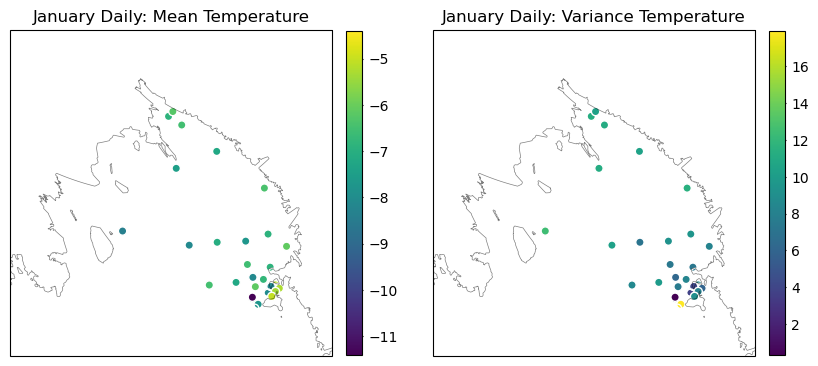

In [15]:
#Plotting Observational Data Mean Temperature
map_proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0, globe=None)
fig, axs = plt.subplots(1, 2, subplot_kw={"projection": map_proj}, figsize=(10, 10))
plots=[]
params = ['Mean Temperature','Variance Temperature']
masked_ds = ds_subset.where(ds_subset.ross_mask)

for param,ax in zip(params,axs):
    plots.append(masked_ds[params].plot.scatter(x="Lon(°C)",y="Lat(°C)",transform=ccrs.PlateCarree(),ax=ax,add_colorbar=False,hue=param))
    ax.coastlines(alpha=0.5,linewidth=0.5)
    ax.set_title(f"January Daily: {param}")
for plot, ax in zip(plots, axs.ravel()):
    cbar = fig.colorbar(plot, ax=ax,fraction=0.046, pad=0.04)
    cbar.ax.tick_params(size=1)

In [3]:
# Create grid coordinates that are Euclidean
rotated_coord_system = ccrs.RotatedGeodetic(
    13.079999923706055,
    0.5199999809265137,
    central_rotated_longitude=180.0,
    globe=None,
)

lon=ds_subset["Lon(°C)"]
lat=ds_subset["Lat(°C)"]

transformer = Transformer.from_crs("epsg:4326", rotated_coord_system)
glat,glon = transformer.transform(lat,lon)

ds_subset = ds_subset.assign_coords(grid_longitude=("Station_Lower", glon))
ds_subset = ds_subset.assign_coords(grid_latitude=("Station_Lower", glat))

In [59]:
antarctica_gdf = gpd.read_file(
    f"{base_path}data/Antarctica_Shapefile/antarctica_shapefile.shp"
)

antarctica_gdf = antarctica_gdf.to_crs(rotated_coord_system)

In [14]:
ds_subset['Mean Temperature'] = ds_subset['Temperature()'].sel(Month=1).mean(['Year','Day'])
ds_subset['Variance Temperature'] = ds_subset['Temperature()'].sel(Month=1).var(['Year','Day'])

/home/jez/anaconda3/envs/BC/lib/python3.9/site-packages/xarray/core/nputils.py:157: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


In [120]:
ds_subset['Mean Temperature 2000'] = ds_subset['Temperature()'].sel(Month=1,Year=2000).mean(['Day'])
ds_subset['Variance Temperature 2000'] = ds_subset['Temperature()'].sel(Month=1,Year=2000).var(['Day'])

/home/jez/anaconda3/envs/BC/lib/python3.9/site-packages/xarray/core/nputils.py:157: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


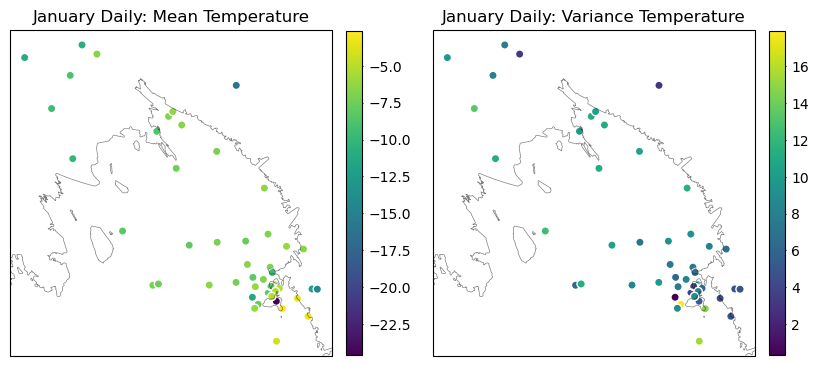

In [51]:
#Plotting Observational Data Mean Temperature
map_proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0, globe=None)
fig, axs = plt.subplots(1, 2, subplot_kw={"projection": map_proj}, figsize=(10, 10))
plots=[]
params = ['Mean Temperature','Variance Temperature']

for param,ax in zip(params,axs):
    plots.append(ds_subset[params].plot.scatter(x="Lon(°C)",y="Lat(°C)",transform=ccrs.PlateCarree(),ax=ax,add_colorbar=False,hue=param))
    ax.coastlines(alpha=0.5,linewidth=0.5)
    ax.set_title(f"January Daily: {param}")
for plot, ax in zip(plots, axs.ravel()):
    cbar = fig.colorbar(plot, ax=ax,fraction=0.046, pad=0.04)
    cbar.ax.tick_params(size=1)

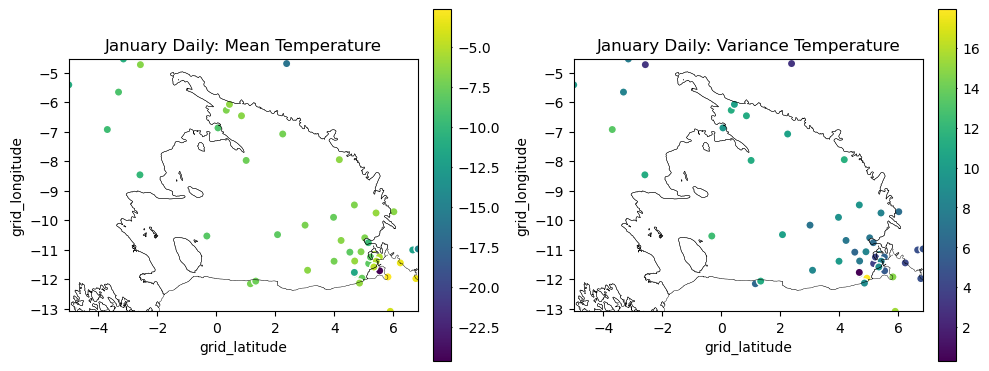

In [82]:
#Plotting Observational Data Mean Temperature
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
plots=[]
params = ['Mean Temperature','Variance Temperature']

for param,ax in zip(params,axs):
    plots.append(ds_subset[params].plot.scatter(x="grid_latitude",y="grid_longitude",ax=ax,add_colorbar=False,hue=param))
    min_x,max_x = ds_subset["grid_latitude"].min(),ds_subset["grid_latitude"].max()
    min_y,max_y = ds_subset["grid_longitude"].min(),ds_subset["grid_longitude"].max()
    ax.set_xlim([min_x,max_x])
    ax.set_ylim([min_y,max_y])
    # ax.set_aspect(abs((max_x-min_x)/(max_y-min_y)))
    ax.set_title(f"January Daily: {param}")
for plot, ax in zip(plots, axs.ravel()):
    cbar = fig.colorbar(plot, ax=ax,fraction=0.046, pad=0.04)
    cbar.ax.tick_params(size=1)
    antarctica_gdf.boundary.plot(ax=ax, color="k", linewidth=0.3)
plt.tight_layout()

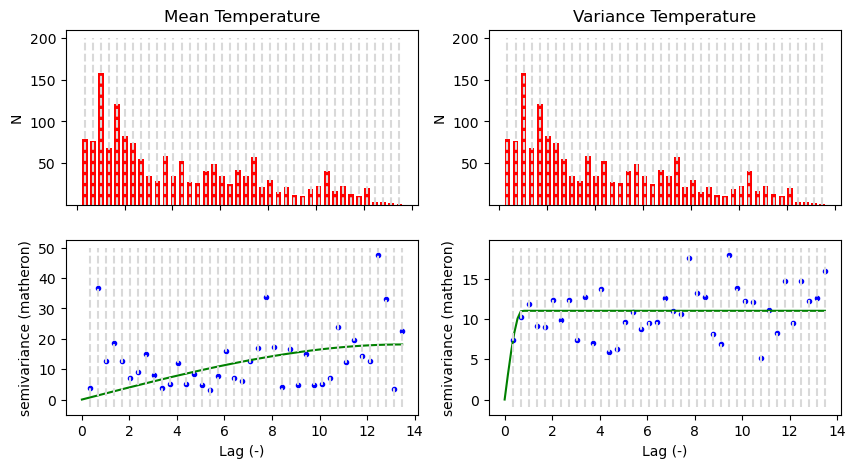

In [96]:
#Plot Semivariograms for Parameters
fig, axs = plt.subplots(2,2,figsize=(10,5))

params = ['Mean Temperature','Variance Temperature']
for param in params:
    da = ds_subset[param].dropna('Station_Lower')
    x,y = da.grid_latitude,da.grid_longitude
    coords = np.dstack([x,y]).reshape(-1,2)
    semivariogram = skg.Variogram(coords, da.data,n_lags=40)
    semivariogram.plot(axes=axs[:,params.index(param)][::-1])
    axs[:,params.index(param)][0].set_title(param)
plt.show()

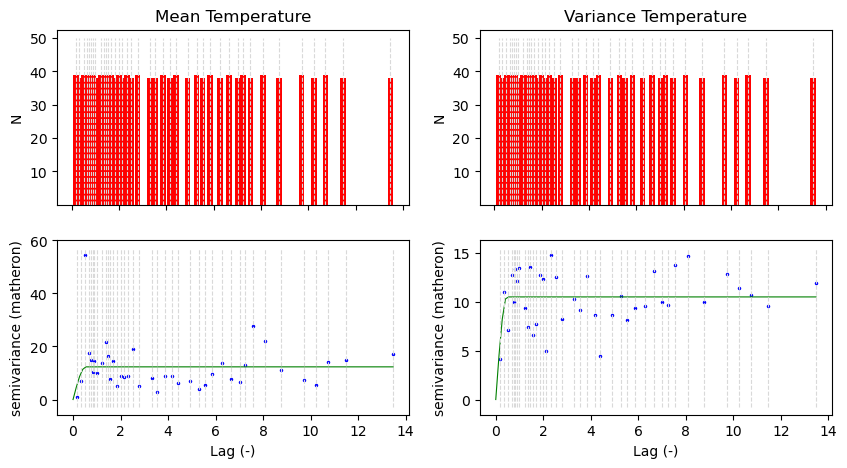

In [116]:
#Plot Semivariograms for Parameters
fig, axs = plt.subplots(2,2,figsize=(10,5))

params = ['Mean Temperature','Variance Temperature']
for param in params:
    da = ds_subset[param].dropna('Station_Lower')
    x,y = da.grid_latitude,da.grid_longitude
    coords = np.dstack([x,y]).reshape(-1,2)
    semivariogram = skg.Variogram(coords, da.data,n_lags=40,bin_func='uniform')
    semivariogram.plot(axes=axs[:,params.index(param)][::-1])
    axs[:,params.index(param)][0].set_title(param)
plt.show()

In [114]:
plt.rcParams['lines.markersize'] = 3
plt.rcParams['lines.linewidth'] = 0.8

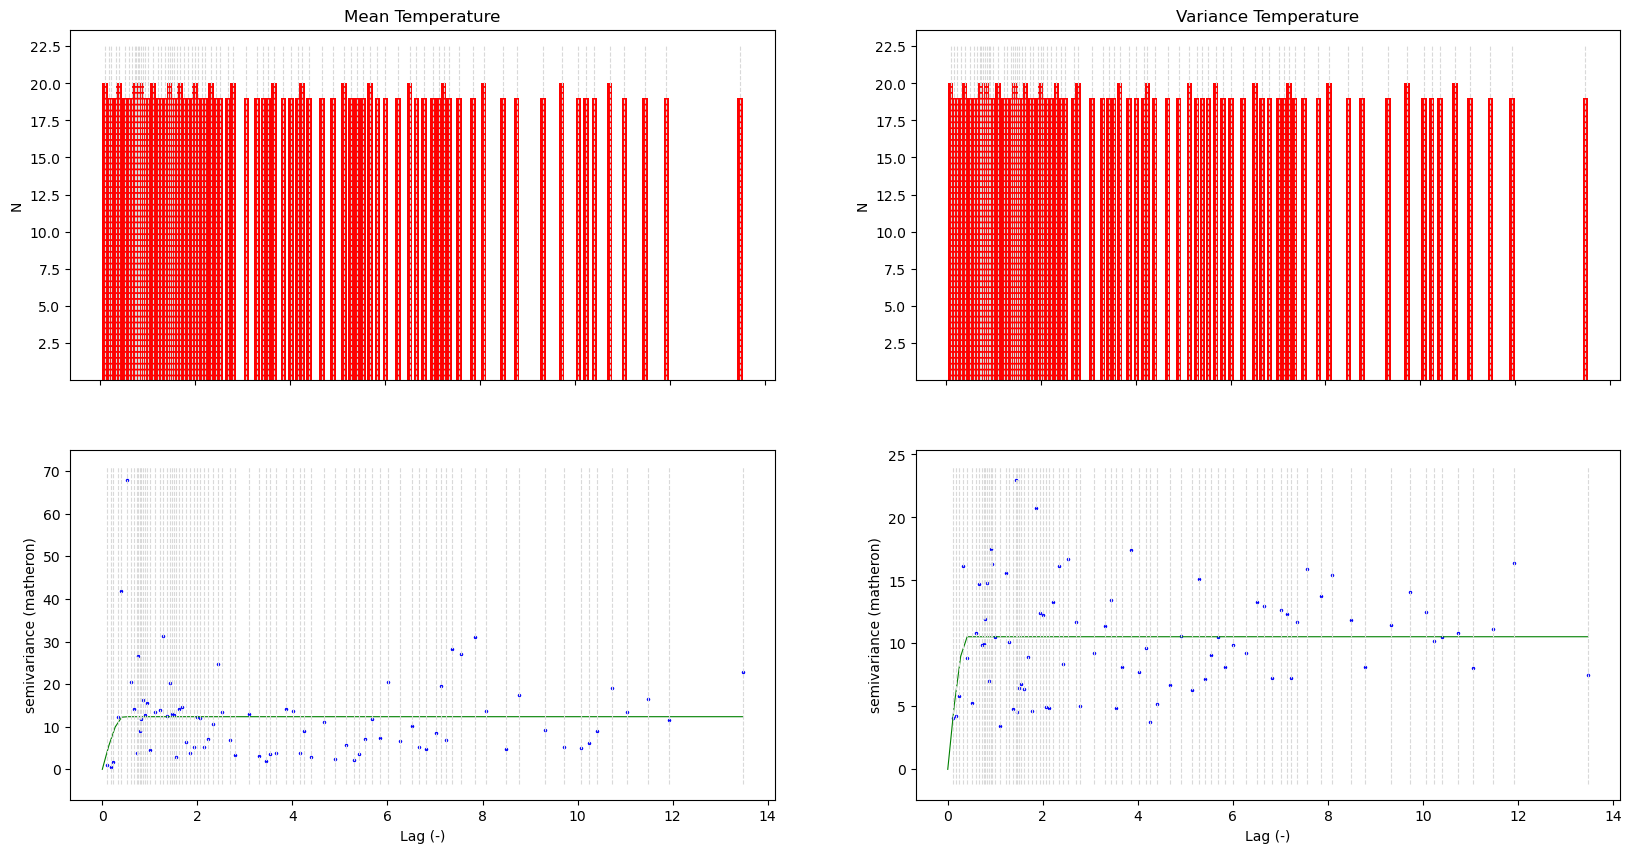

In [115]:
#Plot Semivariograms for Parameters
fig, axs = plt.subplots(2,2,figsize=(20,10))

params = ['Mean Temperature','Variance Temperature']
for param in params:
    da = ds_subset[param].dropna('Station_Lower')
    x,y = da.grid_latitude,da.grid_longitude
    coords = np.dstack([x,y]).reshape(-1,2)
    semivariogram = skg.Variogram(coords, da.data,n_lags=80,bin_func='uniform')
    semivariogram.plot(axes=axs[:,params.index(param)][::-1])
    axs[:,params.index(param)][0].set_title(param)
plt.show()

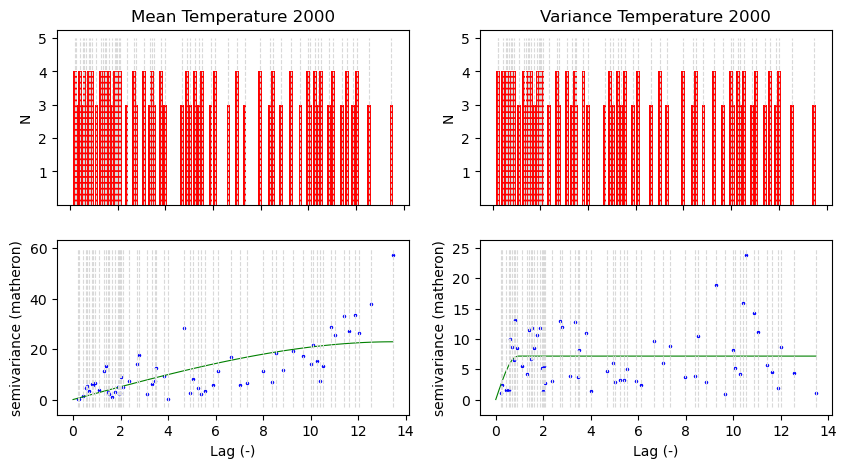

In [126]:
#Plot Semivariograms for Parameters
fig, axs = plt.subplots(2,2,figsize=(10,5))

params = ['Mean Temperature 2000','Variance Temperature 2000']
for param in params:
    da = ds_subset[param].dropna('Station_Lower')
    x,y = da.grid_latitude,da.grid_longitude
    coords = np.dstack([x,y]).reshape(-1,2)
    semivariogram = skg.Variogram(coords, da.data,n_lags=60,bin_func='uniform')
    semivariogram.plot(axes=axs[:,params.index(param)][::-1])
    axs[:,params.index(param)][0].set_title(param)
plt.show()